In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [8]:
input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
lerning_rate = 3e-4
batch_size = 32

class Encoder(nn.Module):
	def __init__(self, input_dim, hidden_dim, latent_dim):
		super(Encoder, self).__init__()
		self.linear = nn.Linear(input_dim, hidden_dim)
		self.linear_mu = nn.Linear(hidden_dim, latent_dim)
		self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

	def forward(self, x):
		h = self.linear(x)
		h = F.relu(h)
		mu = self.linear_mu(h)
		logvar = self.linear_logvar(h)
		sigma = torch.exp(0.5*logvar)
		return mu, sigma
	
class Decoder(nn.Module):
	def __init__(self, latent_dim, hidden_dim, output_dim):
		super(Decoder, self).__init__()
		self.linear1 = nn.Linear(latent_dim, hidden_dim)
		self.linear2 = nn.Linear(hidden_dim, output_dim)

	def forward(self, z):
		h = self.linear1(z)
		h = F.relu(h)
		h = self.linear2(h)
		x_hat = F.sigmoid(h)
		return x_hat
	

def repameterize(mu, sigma):
	eps = torch.randn_like(sigma)
	return mu + eps * sigma

class VAE(nn.Module):
	def __init__(self, input_dim, hidden_dim, latent_dim):
		super(VAE, self).__init__()
		self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
		self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

	def get_loss(self, x):
		mu, sigma = self.encoder(x)
		z = repameterize(mu, sigma)
		x_hat = self.decoder(z)

		batch_size = len(x)
		L1 = F.mse_loss(x_hat, x, reduction='sum')
		L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
		return (L1 + L2) / batch_size
		

In [9]:
transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Lambda(torch.flatten)
])

dataset = datasets.MNIST(
  root='./data',
	train=True,
	download=True,
	transform=transforms
)

dataloader = torch.utils.data.DataLoader(
	dataset,
	batch_size=batch_size,
	shuffle=True
)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lerning_rate)
losses = []

for epoch in range(epochs):
	loss_sum = 0.0
	cnt = 0
	for x, label in dataloader:
		optimizer.zero_grad()
		loss = model.get_loss(x)
		loss.backward()
		optimizer.step()
		
		loss_sum += loss.item()
		cnt += 1
	
	loss_avg = loss_sum / cnt
	losses.append(loss_avg)
	print(loss_avg)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 926807.66it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156574.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 292090.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2891262.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

54.12730560913086
45.427950083414714
43.339668530273435
42.216785237630205
41.599443581136065
41.12399486490885
40.80263340861003
40.533946248372395
40.31940413208008
40.10810693155924
39.967002742513024
39.8492263285319
39.71773028157552
39.605330865478514
39.56801566772461
39.44002907104492
39.370788665771485
39.289541379801435
39.25495459187825
39.15347860717773
39.1008179280599
39.060605813598634
38.981074096679684
38.954973588053385
38.88033515625
38.84286924031576
38.82949692179362
38.78039954325358
38.739043564860026
38.74608479003906


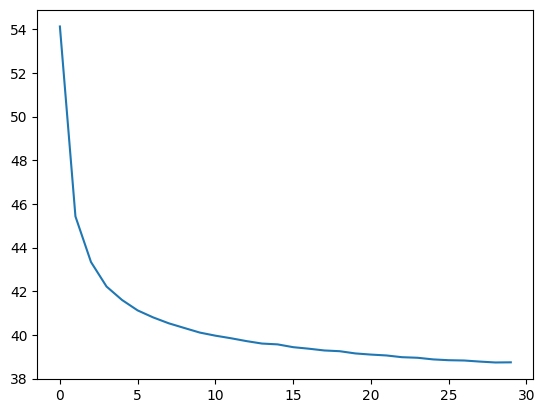

In [10]:
plt.plot(losses)

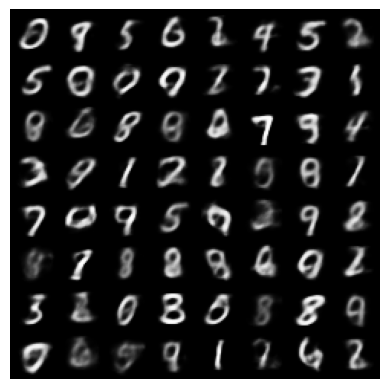

In [16]:
with torch.no_grad():
  sample_size = 64
  z = torch.randn(sample_size, latent_dim)
  x = model.decoder(z)
  generated_images = x.view(sample_size, 1, 28, 28)
  
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()